---
클래스 지정 하지 않은 테스트, 원리 파악용<br>
Playground

In [14]:
import xml.etree.ElementTree as ET
import torch

def class_to_idx(label, class_mapping):
    return class_mapping[label]

# Example class mapping dictionary
class_mapping = {
    'red apple': 1,
    'green apple': 2,
}

# Parse the XML file
tree = ET.parse('annotations/apple10_jpg.rf.3c9df9e888768e471d4d2dd2cfcbce46.xml')
root = tree.getroot()

# Initialize lists to hold box coordinates and labels
boxes = []
labels = []

# Iterate over all objects in the XML
for obj in root.iter('object'):
    name = obj.find('name').text
    xmlbox = obj.find('bndbox')
    xmin = int(xmlbox.find('xmin').text)
    ymin = int(xmlbox.find('ymin').text)
    xmax = int(xmlbox.find('xmax').text)
    ymax = int(xmlbox.find('ymax').text)
    boxes.append([xmin, ymin, xmax, ymax])
    labels.append(name)

# Convert boxes and labels to tensors
boxes = torch.as_tensor(boxes, dtype=torch.float32)
labels = torch.as_tensor([class_to_idx(label, class_mapping) for label in labels], dtype=torch.int64)

print(boxes)
print(labels)


tensor([[274., 187., 363., 268.],
        [496., 162., 606., 267.],
        [151., 176., 252., 270.]])
tensor([1, 1, 2])


In [2]:
# cuda 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


---
데이터로더 확인하기

In [16]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import xml.etree.ElementTree as ET
from PIL import Image

# 클래스 이름을 인덱스로 매핑하는 함수
def class_to_idx(label, class_mapping):
    return class_mapping[label]

# Example class mapping dictionary
class_mapping = {
    'red apple': 1,
    'green apple': 2,
}

# Dataset 지정
class CustomDataset(Dataset):
    def __init__(self, img_dir, anno_dir, class_mapping, transforms=None):
        self.img_dir = img_dir
        self.anno_dir = anno_dir
        self.class_mapping = class_mapping
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(img_dir)))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        anno_path = os.path.join(self.anno_dir, self.imgs[idx].replace('.jpg', '.xml'))
        
        img = Image.open(img_path).convert("RGB")
        
        # XML 파일에서 annotation 정보 추출
        tree = ET.parse(anno_path)
        root = tree.getroot()
        
        boxes = []
        labels = []
        for obj in root.iter('object'):
            name = obj.find('name').text
            xmlbox = obj.find('bndbox')
            xmin = int(xmlbox.find('xmin').text)
            ymin = int(xmlbox.find('ymin').text)
            xmax = int(xmlbox.find('xmax').text)
            ymax = int(xmlbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(name)
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor([class_to_idx(l, self.class_mapping) for l in labels], dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target



In [17]:
# 데이터셋, 데이터로더 지정

def collate_fn(batch):
    imgs, targets = zip(*batch)
    return list(imgs), list(targets)

dataset = CustomDataset('images', 'annotations', class_mapping, transforms=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)

# Dataloader 테스트 용 코드
import matplotlib.pyplot as plt
import torch

def test_dataloader(dataloader):
    for imgs, targets in dataloader: 
        for i in range(len(imgs)):
            # 배치의 첫 번째 이미지만 선택
            img = imgs[i]

            # (3, 480, 640) 형태를 (480, 640, 3)으로 변환
            img = img.permute(1, 2, 0)

            # 텐서를 NumPy 배열로 변환
            img_np = img.numpy()

            # 이미지 표시
            plt.imshow(img_np)
            plt.axis('off')  # 축 제거
            plt.show()
            print("Image", i)
            print("Image shape:", imgs[i].shape)
            print("Boxes:", targets[i]['boxes'])
            print("Labels:", targets[i]['labels'])
        break  # 첫 번째 배치만 테스트

# 테스트 함수 실행
# test_dataloader(dataloader)

---
모델 정의하기

In [18]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
import numpy as np
from PIL import Image
import os
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

def get_model(num_classes):
    # 사전 학습된 모델 로드
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # 클래스 수에 맞게 분류 헤드 수정
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# 모델 인스턴스 생성
num_classes = 2 + 1  # 2개의 클래스 (red apple, green apple) + 배경
model = get_model(num_classes)

# 디바이스 설정 (GPU 사용 가능 시 GPU 사용)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

---
학습하기

In [21]:
# Optimizer 설정
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler 설정
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# 훈련 루프
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in dataloader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        
        print(f"Epoch: {epoch+1}, Step: {i+1}, Loss: {losses.item()}")
        i += 1
    
    lr_scheduler.step()

print("Training complete!")


Epoch: 0, Step: 0, Loss: 0.2427976280450821
Epoch: 0, Step: 1, Loss: 0.2646990716457367
Epoch: 0, Step: 2, Loss: 0.2367798238992691
Epoch: 0, Step: 3, Loss: 0.3201253414154053
Epoch: 0, Step: 4, Loss: 0.41187480092048645
Epoch: 0, Step: 5, Loss: 0.35001590847969055
Epoch: 1, Step: 0, Loss: 0.23312367498874664
Epoch: 1, Step: 1, Loss: 0.22722947597503662
Epoch: 1, Step: 2, Loss: 0.21976955235004425
Epoch: 1, Step: 3, Loss: 0.17270644009113312
Epoch: 1, Step: 4, Loss: 0.35327109694480896
Epoch: 1, Step: 5, Loss: 0.256824791431427
Epoch: 2, Step: 0, Loss: 0.17493228614330292
Epoch: 2, Step: 1, Loss: 0.23526135087013245
Epoch: 2, Step: 2, Loss: 0.19030512869358063
Epoch: 2, Step: 3, Loss: 0.14076676964759827
Epoch: 2, Step: 4, Loss: 0.16497832536697388
Epoch: 2, Step: 5, Loss: 0.18709684908390045
Epoch: 3, Step: 0, Loss: 0.14934681355953217
Epoch: 3, Step: 1, Loss: 0.18261456489562988
Epoch: 3, Step: 2, Loss: 0.2134697586297989
Epoch: 3, Step: 3, Loss: 0.14430773258209229
Epoch: 3, Step: 4

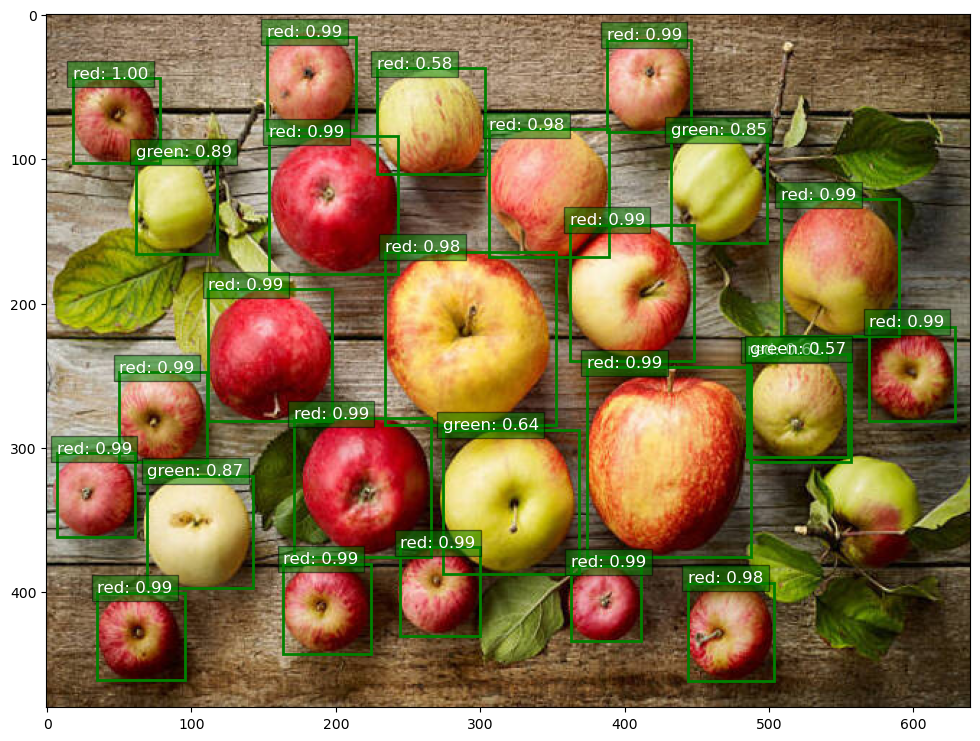

In [24]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# 이미지 불러오기
image_path = 'apple.jpg'
image = Image.open(image_path).convert("RGB")

# 이미지 전처리
transform = transforms.ToTensor()
image_tensor = transform(image).unsqueeze(0)  # 배치 차원을 추가합니다.

# 모델 평가 모드로 전환
model.eval()

# 이미지가 GPU에 있을 경우 GPU로 이동
image_tensor = image_tensor.to(device)

# 예측 수행
with torch.no_grad():
    predictions = model(image_tensor)

# 예측 결과
pred_boxes = predictions[0]['boxes'].cpu().numpy()
pred_labels = predictions[0]['labels'].cpu().numpy()
pred_scores = predictions[0]['scores'].cpu().numpy()

# 시각화
fig, ax = plt.subplots(1, figsize=(12,9))

# 이미지 표시
ax.imshow(image)

def idx_to_class(label):
    return 'red' if label == 1 else 'green'

# 바운딩 박스 그리기
for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
    if score > 0.5:  # confidence threshold 설정
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin
        edgecolor = 'r' if label == 0 else 'g'  # red apple은 빨간색, green apple은 초록색
        rect = patches.Rectangle((xmin, ymin), width, height, edgecolor=edgecolor, facecolor='none', linewidth=2)
        ax.add_patch(rect)
        label_name = idx_to_class(label)
        ax.text(xmin, ymin, f'{label_name}: {score:.2f}', bbox=dict(facecolor=edgecolor, alpha=0.5), fontsize=12, color='white')

plt.show()


In [25]:
# GPU 메모리 해제
torch.cuda.empty_cache()